In [1]:
#import libraries
import numpy as np
import geopandas as gpd
import shapely 
import matplotlib.pyplot as plt
import os
#import seaborn as sns
import pandas as pd
import sklearn

C:\Users\Thinkpad\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# user should replace with their directory
data_dir = os.environ.get('DATA_DIR', )

csv_path = os.path.join(data_dir, 'cook_county_gdf_intro_semiannual.csv')
cook_county_gdf = pd.read_csv(csv_path) 

In [3]:
# add in missing 56 tracts
cook_county_gdf['semiannual'].fillna(9999, inplace=True) 
cook_county_gdf['year'].fillna(9999, inplace=True)

In [4]:
cook_county_gdf.loc[cook_county_gdf['year'] == 9999, 'geoid'].nunique() #should be 56

56

In [5]:
columns_to_keep = [
    'INTPTLAT', 'INTPTLON',
    'STATEFP', 'COUNTYFP', 'TRACTCE','NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
    'geometry']

gdf_semi = cook_county_gdf.groupby(['geoid', 'semiannual', 'year']).agg({'deaths': 'sum', **{col: 'first' for col in columns_to_keep}}).reset_index()

### Making DF square - one "semi-annual" period for each tract

In [6]:
gdf_semi.loc[gdf_semi['year'] == 9999, 'deaths'] = 0
gdf_semi.loc[gdf_semi['semiannual'] == 9999, 'deaths'] = 0

# Replace 9999 with 2015 in the 'year' column
gdf_semi['year'].replace(9999, 2015, inplace=True)
gdf_semi['semiannual'].replace(9999, 1, inplace=True)

In [7]:
gdf_semi['geoid'].nunique()  #should be 1332

1332

In [8]:
# Fill in missing tract-year-period cells
# Warning: Nested for loops

years = range(2015, 2024)
periods = [1, 2]

existing_combinations = set(zip(gdf_semi['geoid'], gdf_semi['year'], gdf_semi['semiannual']))
updated_rows = []

for tract in gdf_semi['geoid'].unique():
    for year in years:
        for period in periods:
            combination = (tract, year, period)
            if combination not in existing_combinations:
                new_row = {'geoid': tract, 'year': year, 'semiannual': period, 'deaths': 0}
                updated_rows.append(new_row)

gdf_semi = pd.concat([gdf_semi, pd.DataFrame(updated_rows)], ignore_index=True)

In [9]:
#fills in NAs produced from above
unique_tracts = gdf_semi['geoid'].unique()

for tract in unique_tracts:
    tract_rows = gdf_semi[gdf_semi['geoid'] == tract]
    non_na_row = tract_rows.dropna().iloc[0]  # Get the first row without any NAs
    
    for column in columns_to_keep:
        gdf_semi.loc[(gdf_semi['geoid'] == tract) & gdf_semi[column].isna(), column] = non_na_row[column]

In [10]:
gdf_semi.shape #should be (24162, 15)


(24162, 16)

In [11]:
# Confirms all years for each geoid present
years = range(2015, 2023)  # data collect started in late '14, we ran this notebook in mid '23

periods = [1, 2]  

for tract in gdf_semi['geoid'].unique():
    for year in years:
        for period in periods:
            if not ((gdf_semi['geoid'] == tract) & (gdf_semi['year'] == year) & (gdf_semi['semiannual'] == period)).any():
                print("Missing row for geoid {} in year {} semiannual {}".format(tract, year, period))


In [12]:
#Any NAs in data frame?

has_na = gdf_semi.isna().any().any()

if has_na:
    print("There are missing values in the dataframe.")
else:
    print("There are no missing values in the dataframe.")


There are no missing values in the dataframe.


In [13]:
#Any Duplicates?
has_duplicates = gdf_semi.duplicated().any()

if has_duplicates:
    print("There are duplicate rows in the dataframe.")
else:
    print("There are no duplicate rows in the dataframe.")


There are no duplicate rows in the dataframe.


In [14]:
#change format of year and semiannuals

gdf_semi['year'] = pd.to_datetime(gdf_semi['year'].astype(int).astype(str), format='%Y').dt.year
gdf_semi['semiannual'] = gdf_semi['semiannual'].astype(str).replace('1.0', '1').replace('2.0', '2')


In [15]:
#take out 2023 and 2014
gdf_semi = gdf_semi[gdf_semi['year'] != 2023]
gdf_semi = gdf_semi[gdf_semi['year'] != 2014]

In [16]:
sorted(gdf_semi.year.unique())

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [17]:
#gdf_semi.columns = ['geoid', 'semiannual', 'year', 'deaths', 'STATEFP', 'COUNTYFP',
#       'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
#       'lat', 'lon', 'geometry']

In [18]:
# Create timestep column
gdf_semi = gdf_semi.sort_values(by=['geoid', 'year', 'semiannual']).reset_index(drop=True).copy()

gdf_semi['timestep'] = gdf_semi.groupby(['geoid']).cumcount() + 1

# Create season column
def map_season(semiannual):
    return 'jan-jun' if semiannual == '1' else 'jul-dec'
gdf_semi['season'] = gdf_semi['semiannual'].map(map_season)

In [19]:
# Create 'year_frac' column that indicates timeperiod in fractional years
gdf_semi['year_frac'] = gdf_semi['year'].values + (gdf_semi['semiannual'].values.astype('int') - 1)/2

In [20]:
gdf_semi.columns

Index(['geoid', 'semiannual', 'year', 'deaths', 'INTPTLAT', 'INTPTLON',
       'STATEFP', 'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'geometry', 'timestep', 'season',
       'year_frac'],
      dtype='object')

In [21]:
# REORDER columns to be easier for humans to inspect
gdf_semi = gdf_semi[[
    'geoid', 'timestep', 'year_frac', 
    'deaths',
    'year', 'semiannual', 'season']
    + columns_to_keep
    ].copy()


In [22]:
gdf_semi.head()

,geoid,timestep,year_frac,deaths,year,semiannual,season,INTPTLAT,INTPTLON,STATEFP,COUNTYFP,TRACTCE,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,geometry
0,17031010100,1,2015.0,0,2015,1,jan-jun,42.021255,-87.66983,17.0,31.0,10100.0,101.0,Census Tract 101,G5020,S,379511.0,0.0,"POLYGON ((-87.677199 42.022942, -87.676277 42...."
1,17031010100,2,2015.5,1,2015,2,jul-dec,42.021255,-87.66983,17.0,31.0,10100.0,101.0,Census Tract 101,G5020,S,379511.0,0.0,"POLYGON ((-87.677199 42.022942, -87.676277 42...."
2,17031010100,3,2016.0,2,2016,1,jan-jun,42.021255,-87.66983,17.0,31.0,10100.0,101.0,Census Tract 101,G5020,S,379511.0,0.0,"POLYGON ((-87.677199 42.022942, -87.676277 42...."
3,17031010100,4,2016.5,1,2016,2,jul-dec,42.021255,-87.66983,17.0,31.0,10100.0,101.0,Census Tract 101,G5020,S,379511.0,0.0,"POLYGON ((-87.677199 42.022942, -87.676277 42...."
4,17031010100,5,2017.0,1,2017,1,jan-jun,42.021255,-87.66983,17.0,31.0,10100.0,101.0,Census Tract 101,G5020,S,379511.0,0.0,"POLYGON ((-87.677199 42.022942, -87.676277 42...."


In [23]:
#convert back to gdf
from shapely import wkt

gdf_semi['geometry'] = gdf_semi['geometry'].apply(wkt.loads)

gdf_semi = gpd.GeoDataFrame(gdf_semi, geometry='geometry')
gdf_semi.crs = {'init': 'EPSG:4269'}
type(gdf_semi)

C:\Users\Thinkpad\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


geopandas.geodataframe.GeoDataFrame

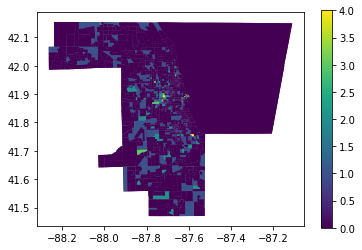

In [24]:
gdf_semi[gdf_semi['year']==2015].plot('deaths', legend=True);

### store gdf


In [25]:
gdf_semi.to_csv(csv_path.replace("intro", "clean"), index=False)